---
### 8.4.1 Malthus 模型
设自然增长率 $r$ 为常数，则 $t$ 时刻的人口数量为
$$x(t)=x_0{\rm e}^{r\left(t-t_0\right)}$$
当 $t$ 较大时，模型给出的结果显著偏大，这是由于对 $r$ 的估计过高。因此，可以对 $r$ 是常数的假设提出疑问

In [1]:
import numpy as np
import pandas as pd
import sympy as sp
sp.init_printing(use_latex=True)
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Times New Roman + SimSun + WFM Sans SC']
plt.rcParams['mathtext.fontset']='stix'
# Times New Roman + SimSun + WFM Sans SC
# simsum宋体, times new roman -*, simhei黑体, kaiti楷体, 
# dengxian等线, fangsong仿宋, Microsoft Yahei微软雅黑
plt.rcParams['axes.unicode_minus']=False   
plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = [4, 3]
# plt.rcParams['font.size'] = 12
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'

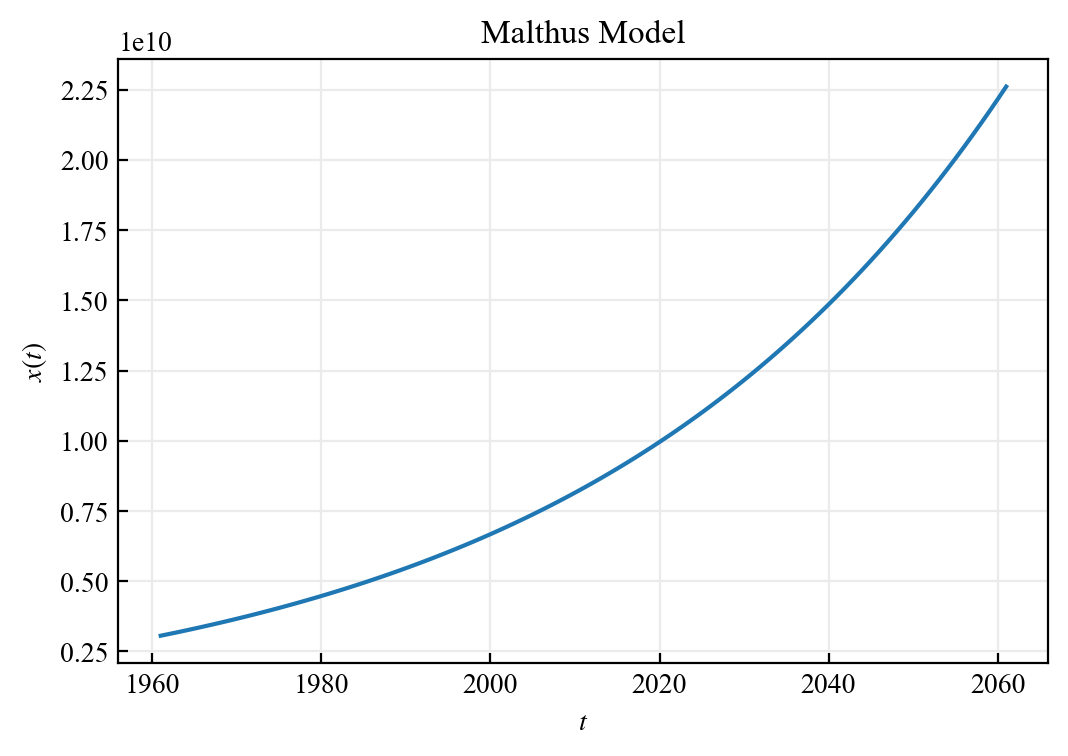

In [2]:
def Malthus(t, u):
    x0, r, t0 = u
    return x0*np.exp(r*(t-t0))

x0, r, t0 = 3.06e9, 0.02, 1961
u = np.array([x0, r, t0])
t = np.linspace(t0, t0+100, 101)
x = Malthus(t, u)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t, x)
ax.set_xlabel('$t$')
ax.set_ylabel('$x(t)$')
ax.grid(color='0.92')
ax.set_title("Malthus Model")
fig.show()

### 8.4.2 Logistic 模型
将增长率 $r$ 表示为人口 $x(t)$ 的减函数，$x_m$ 为最大容纳量，则有
$$x{\left(t \right)} = \dfrac{x_{m}}{1+\left(\dfrac{x_m}{x_0} - 1\right){\rm e}^{-r\left(t-t_0\right)}}$$

根据数据拟合参数，预报 2010 年美国人口
#### 1. 非线性最小二乘估计

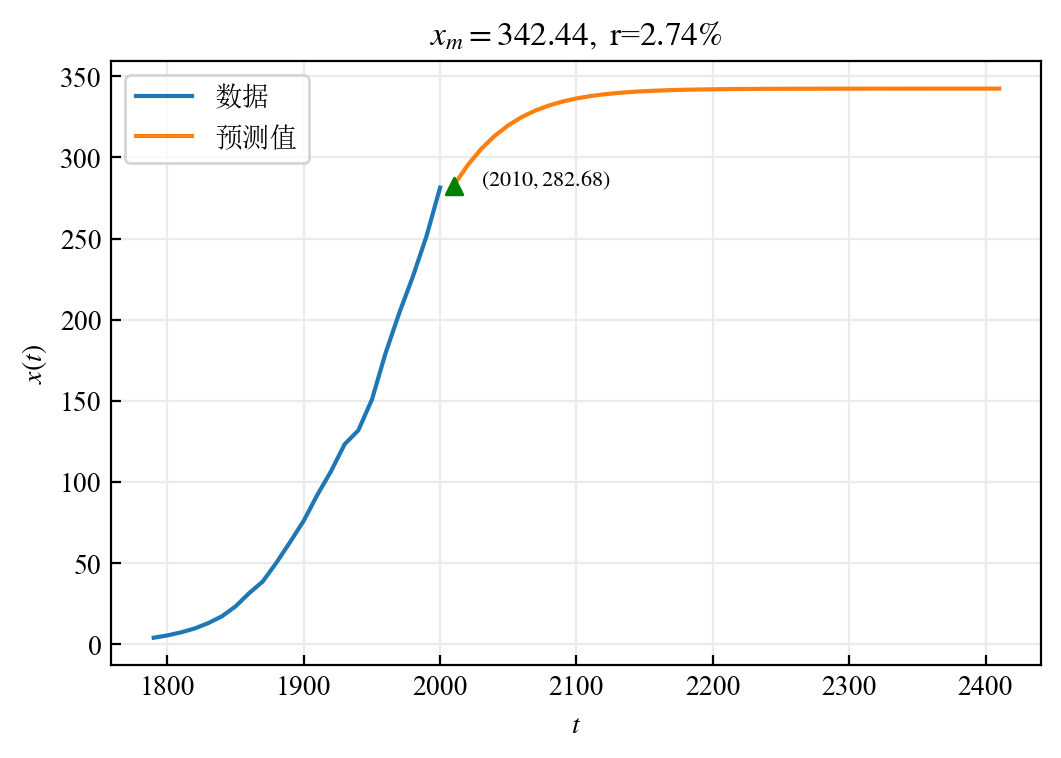

In [3]:
from scipy.optimize import curve_fit

data = pd.read_excel('../../08第8章  常微分方程与差分方程/data8_13.xlsx', header=None).values
tt = data[::2].flatten()[:-2]
xx = data[1::2].flatten()[:-2]

t0, x0 = tt[0], xx[0]

def Logistic(t, xm, r):
    return xm/(1+(xm/x0 - 1)*np.exp(-r*(t-t0)))

def drawLogistic(xm, r):
    t = np.arange(2010, 2010+410, 10)
    x = Logistic(t, xm, r)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(tt, xx, label='数据')
    ax.plot(t, x, label='预测值')
    ax.scatter(t[0], x[0], marker='^', color='g', zorder=10)
    ax.text(t[0]+20, x[0], f'$(2010,{x[0]:.2f})$', fontsize=8)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x(t)$')
    ax.set_title(f'$x_m={xm:.2f},\ $r=${100*r:.2f}\%$')
    ax.grid(color='0.92')
    ax.legend()
    return fig, ax

LB, UB = [280, 0], [2000, 1]
u = curve_fit(Logistic, tt[1:], xx[1:], bounds=(LB, UB))[0]
xm, r = u
fig, ax = drawLogistic(xm, r)

#### 2. 向前差分
   $$
   \dfrac{1}{x(k)}\dfrac{x(k+1)-x(k)}{\Delta t}=r-sx(k),\quad k=1,2,\cdots,21
   $$
   求解 $r$，$s=r/x_m$

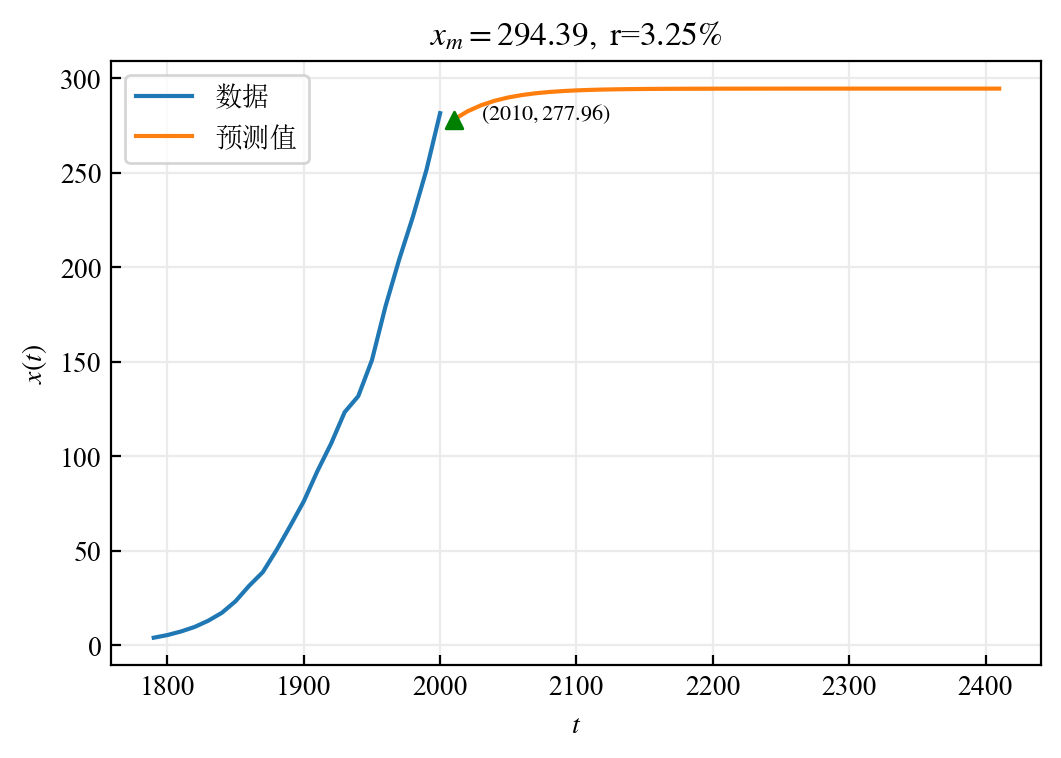

In [4]:
n = len(xx)
A = np.vstack([np.ones(n-1), -xx[:-1]]).T
delta_t = np.diff(tt)[0]
b = np.array([(1/xx[:-1])*np.diff(xx)/delta_t]).flatten()
r, s = np.linalg.pinv(A) @ b
xm = r / s

fig, ax = drawLogistic(xm, r)

#### 3. 向后差分
   $$
   \dfrac{1}{x(k)}\dfrac{x(k)-x(k-1)}{\Delta t}=r-sx(k),\quad k=2,3,\cdots,22
   $$

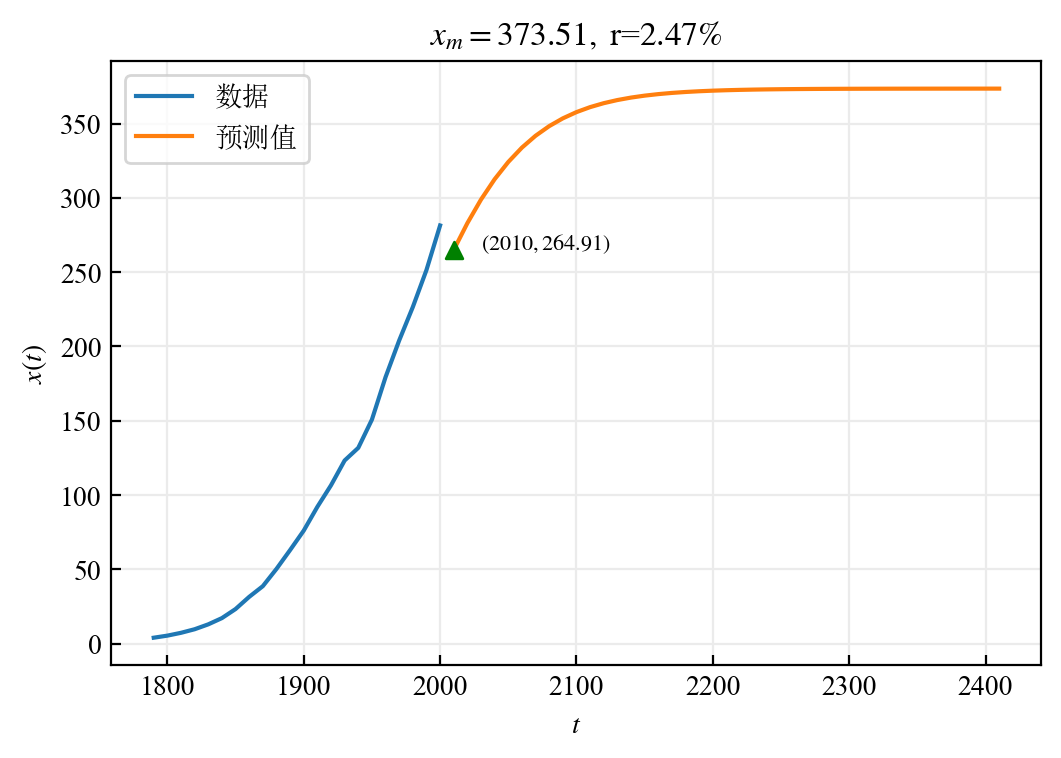

In [5]:
A = np.vstack([np.ones(n-1), -xx[1:]]).T
delta_t = np.diff(tt)[0]
b = np.array([(1/xx[1:])*np.diff(xx)/delta_t]).flatten()
r, s = np.linalg.pinv(A) @ b
xm = r / s

fig, ax = drawLogistic(xm, r)

### 8.4.3 两个种群的相互作用模型
#### 1. 种群竞争模型
考虑两个种群，数量分别为 $x_1(t)$，$x_2(t)$，若第二个种群每个个体消耗资源量相当于第一个种群每个个体的 $\alpha_1$ 倍，$\alpha_2$ 同理，则 $x_1(t)$，$x_2(t)$ 应满足微分方程组：
$$
\begin{cases}
\dfrac{{\rm d}x_1}{{\rm d}t}=r_1\left(1-\dfrac{x_1+\alpha_1x_2}{K_1}\right)x_1\\[2ex]
\dfrac{{\rm d}x_2}{{\rm d}t}=r_2\left(1-\dfrac{x_2+\alpha_1x_1}{K_2}\right)x_2\\[2ex]
x_1(0)=x_1^0,\ x_2(0)=x_2^0
\end{cases}
$$

#### 2. 弱肉强食问题
假设 $x_1$ 捕食 $x_2$，单位时间内第一个种群的单位个体与第二个种群的有效接触数为 $b_{12}x_2(t)$，其中 $b_{12}>0$为比例系数，$b_{12}$同理，则 $x_1(t)$，$x_2(t)$ 应满足微分方程组：
$$
\begin{cases}
\dfrac{{\rm d}x_1}{{\rm d}t}=r_1\left(1-\dfrac{x_1}{K_1}\right)x_1+b_{12}x_1x_2\\[2ex]
\dfrac{{\rm d}x_2}{{\rm d}t}=r_2\left(1-\dfrac{x_2}{K_2}\right)x_2-b_{21}x_1x_2\\[2ex]
x_1(0)=x_1^0,\ x_2(0)=x_2^0\\
\end{cases}
$$
该模型是经典的捕食者-被捕食者模型的一种形式，更多的讨论可以基于食物链中各种群的增长规律以及种群之间的相互依存关系

把类似的讨论应用到其他研究领域，也可得到相似的模型，如市场中同类商品价格的相互竞争问题等

1. 捕食者-被捕食者方程组 
   $$
   \begin{cases}
   \dfrac{{\rm d}x}{{\rm d}t}=ax-bxy, &x(0)=60\\[2ex]
   \dfrac{{\rm d}y}{{\rm d}t}=-cy+dxy, &y(0)=30
   \end{cases}
   $$
   $x(t)$，$y(t)$ 分别表示兔子、狐狸数量，根据观测值拟合 $a$，$b$，$c$，$d$
   
   [SOL]：对应的差分方程为
   $$
   \begin{cases}
   (x_{k+1}-x_k)/(t_{k+1}-t_k)=ax_k-bx_ky_k,\\
   (y_{k+1}-y_k)/(t_{k+1}-t_k)=-cy_k+dx_ky_k,
   \end{cases}
   \quad k=0,1,\cdots,11
   $$
   改写为矩阵形式：
   $$
   \begin{bmatrix}
   x_k   &-x_ky_k &0    &0\\
   0     &0       &-y_k &x_ky_k 
   \end{bmatrix}
   \begin{bmatrix}
   a\\b\\c\\d
   \end{bmatrix}
   =
   \begin{bmatrix}
   (x_{k+1}-x_k)/(t_{k+1}-t_k)\\
   (y_{k+1}-y_k)/(t_{k+1}-t_k)
   \end{bmatrix}
   ,\quad k=0,1,\cdots,11
   $$

In [6]:
t0 = np.array([0,1,2,3,4,5,6,8,10,12,14,16,18])
x0 = np.array([60,63,64,63,61,58,53,44,39,38,41,46,53])
y0 = np.array([30,34,38,44,50,55,58,56,47,38,30,27,26])

n = len(t0)
dxdt = np.diff(x0)/np.diff(t0)
dydt = np.diff(y0)/np.diff(t0)
b = np.hstack([dxdt, dydt])
Mat1 = np.vstack([x0[:-1], -x0[:-1]*y0[:-1], np.zeros((2, n-1))]).T
Mat2 = np.vstack([np.zeros(n-1), np.zeros(n-1), -y0[:-1], x0[:-1]*y0[:-1]]).T
A = np.vstack([Mat1, Mat2])
a, b, c, d = np.linalg.pinv(A) @ b
print(f'{a = }\n{b = }\n{c = }\n{d = }')

a = 0.1907363564841954
b = 0.004826048844530006
c = 0.4828866187749619
d = 0.009535749059691082


2. 捕食者-被捕食者方程组
   $$
   \begin{cases}
   \dfrac{{\rm d}x}{{\rm d}t}=0.2x-0.005xy, &x(0)=70\\[2ex]
   \dfrac{{\rm d}y}{{\rm d}t}=-0.5y+0.01xy, &y(0)=40
   \end{cases}
   $$

In [7]:
x, y = sp.symbols('x y', nonneg=True)
eq = [0.2*x - 0.005*x*y, -0.5*y + 0.01*x*y]
x0, y0 = sp.solve(eq)[1].values()
print(f"平衡状态下 {x0 = :.0f}, {y0 = :.0f}")

平衡状态下 x0 = 50, y0 = 40


In [8]:
from scipy.integrate import odeint

x = np.linspace(20, 80, 10)
y = np.linspace(10, 70, 10)
X, Y = np.meshgrid(x, y)
u = 0.2*X - 0.005*X*Y
v = -0.5*Y + 0.01*X*Y

def predator_prey(f, t):
    x, y = f
    return [
        0.2*x - 0.005*x*y,
        -0.5*y + 0.01*x*y,
    ]

t = np.linspace(0, 60, 10000)
ns = odeint(predator_prey, [70, 40], t)
xhat, yhat = ns.T
xmax, xmin = np.round(xhat.max(), 0), np.round(xhat.min(), 0)
ymax, ymin = np.round(yhat.max(), 0), np.round(yhat.min(), 0)
print(f'{xmax = }\t{xmin = }')
print(f'{ymax = }\t{ymin = }')

xmax = 70.0	xmin = 34.0
ymax = 67.0	ymin = 21.0


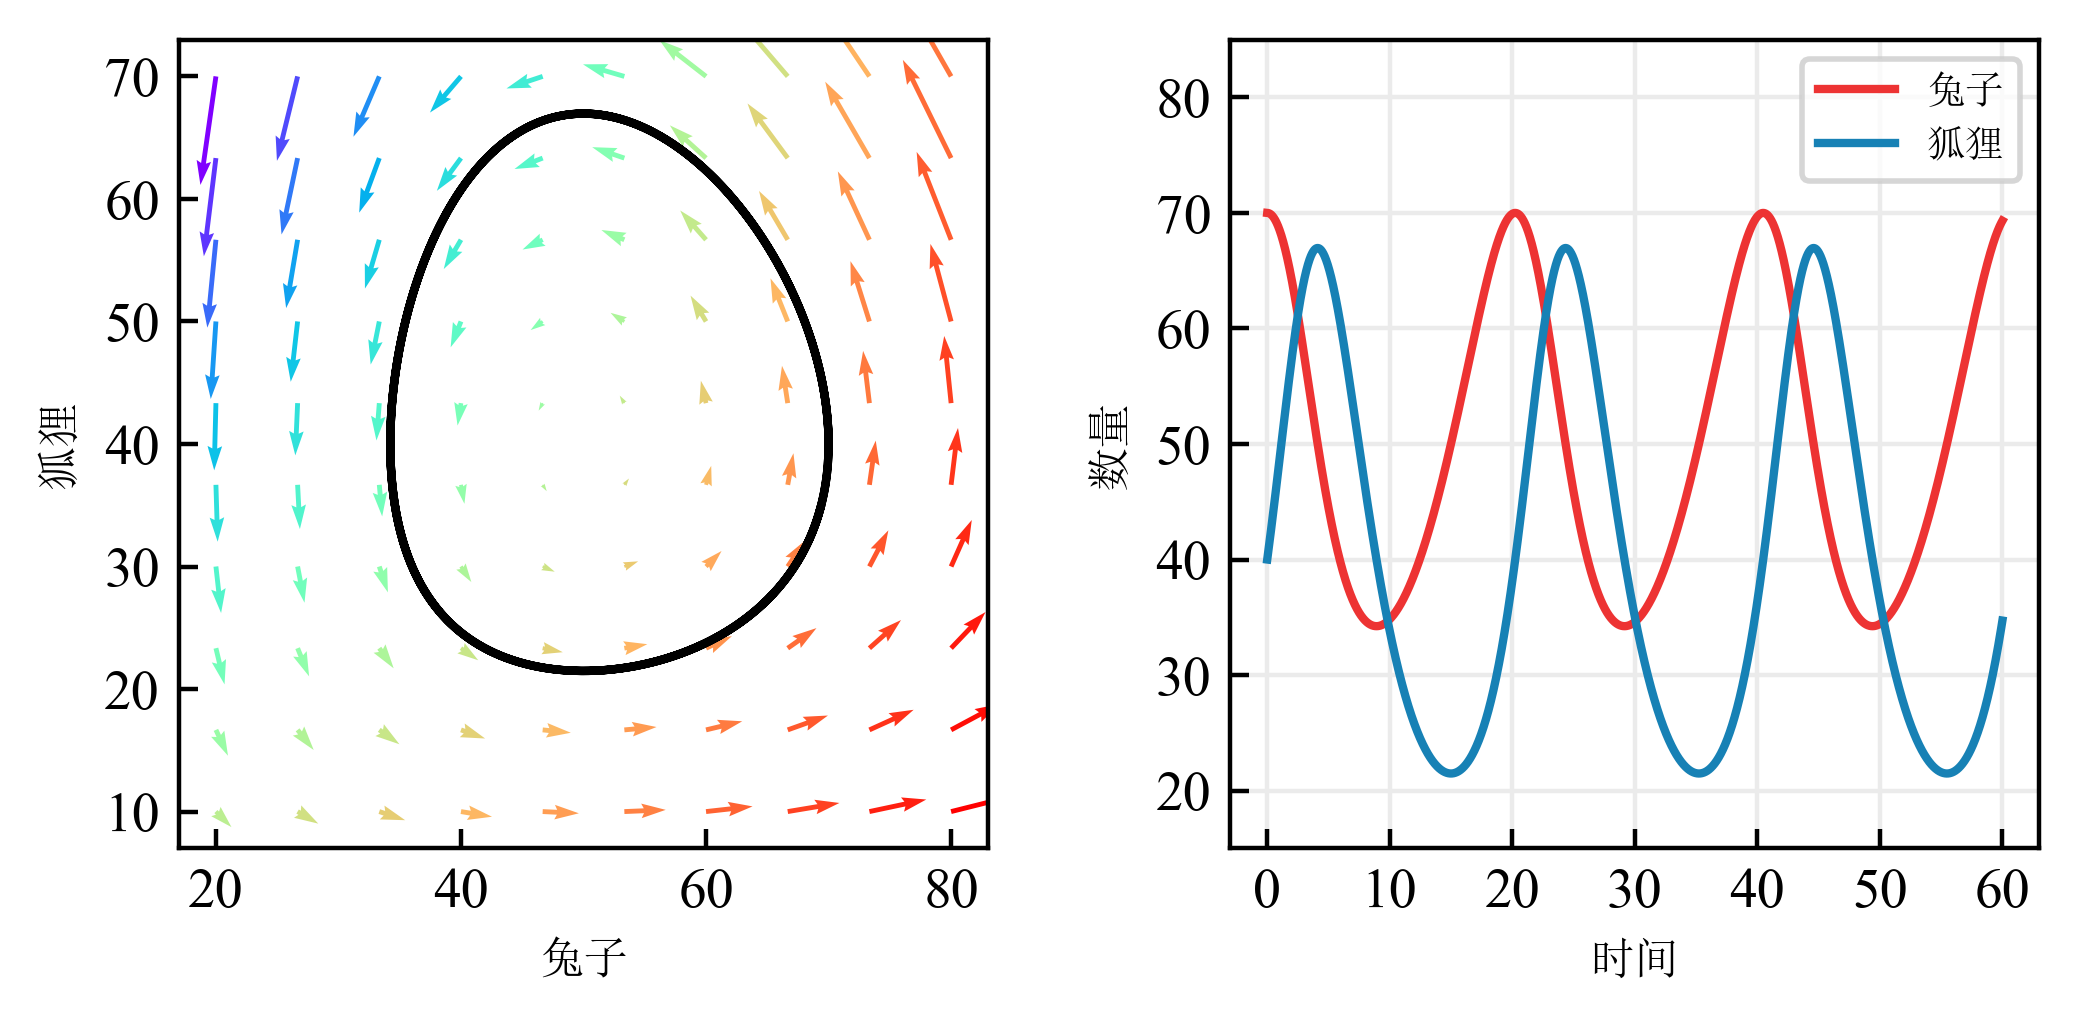

In [9]:
fig = plt.figure(dpi=400)
ax = fig.add_subplot(121)
ax.quiver(x, y, u, v, u+v, cmap='rainbow')
ax.plot(xhat, yhat, 'k')
ax.set_xlabel("兔子", fontsize=8)
ax.set_ylabel("狐狸", fontsize=8)
ax.set_aspect(1)

ax1 = fig.add_subplot(122)
ax1.plot(t, xhat, label='兔子', color='#ed3333')
ax1.plot(t, yhat, label='狐狸', color='#1781b5')
ax1.set_ybound(15, 85)
ax1.set_xlabel("时间", fontsize=8)
ax1.set_ylabel("数量", fontsize=8)
from matplotlib.ticker import MultipleLocator
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax1.legend(fontsize=7)
ax1.grid(color="0.92")
ax1.set_box_aspect(1)

fig.subplots_adjust(wspace=0.3)
fig.show()